In [28]:
import h5py
import os
import ffmpeg
from copy import copy
import numpy as np
import astropy
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from astropy import units as u
from matplotlib.patches import Rectangle
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
#from regions import RectangleSkyRegion, RectanglePixelRegion
#import regions 
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Polygon, PathPatch
from scipy.ndimage import gaussian_filter


import matplotlib.colors as mc
from astropy.table import Table
import matplotlib as mpl
import matplotlib.patheffects as pe


from skimage.draw import rectangle

import matplotlib.pyplot as plt
from numpy import uint32, uint64, float64, float32, linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from scipy.interpolate import griddata, NearestNDInterpolator
from scipy import stats
from matplotlib import figure
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
import matplotlib.patches as patches
import cmasher as cmr
from astropy.io import fits
import pandas as pd
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes
import gc
import glob
gc.enable()


from spectral_cube import SpectralCube

import snapshot_utils as snaput

#import arepy

#%matplotlib inline


In [2]:
### constants: 
kb = 1.38e-23
kb_cgs = 1.38e-16
mH = 1.67e-24 #grams
mCO = 4.65e-23 #grams
mu = 2.8
h = 6.626e-34
h_cgs = 6.62e-27
gamma = 5./3.
pc2cm = 3.086e18
msun2g = 2e33

arepoLength = 3.0856e20
arepoMass = 1.991e33
arepoVel = 1.0e5

pc = 3e18 #1pc = 3e18cm

arepoTime = arepoLength/arepoVel
arepoDensity = arepoMass/arepoLength/arepoLength/arepoLength
arepoEnergy= arepoMass*arepoVel*arepoVel
arepoColumnDensity = arepoMass/arepoLength/arepoLength
arepoVolume = arepoLength*arepoLength*arepoLength

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

def chunk_counting(a):
    #chunk counting (a=[3,2,5] ---> returns [0,1,2, 0,1, 0,1,2,3,4])

    csum = np.cumsum(a)[0:-1]
    csum = np.insert(csum, 0, 0)

    r_csum = np.repeat(csum, a)

    return np.arange(r_csum.size) - r_csum

def find_a_in_b(a, b):
    orig_indices = b.argsort() #this is the most expensive part, especially if b is very large
    b = b[orig_indices]
    
    unique_b, index_start, count = np.unique(b, return_counts=True, return_index=True)
    
    ind = np.searchsorted(unique_b, a)
    
    ind_start = index_start[ind]
    ind_count = count[ind]
    
    ind2 = np.repeat(ind_start, ind_count) + chunk_counting(ind_count)
    
    ind2 = orig_indices[ind2]
    return ind2



####finding indicies in bins
def ind_in_bins(x, y, xedges, yedges):
    # Initialize an empty list to store indices of data points within each bin
    indices_in_bins = []

    # Loop through the x and y bin edges
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):

            # Create a boolean mask to identify data points within the current bin
            in_bin = ((xedges[i] <= x) & (x < xedges[i+1]) & 
                      (yedges[j] <= y) & (y < yedges[j+1]))

            # Find the indices of data points within the current bin
            indices = np.where(in_bin)[0] 

            # Append the indices to the 'indices_in_bins' list
            indices_in_bins.append(indices)
            
    return indices_in_bins

### LV diagram

def XYZhat(xsun,ysun,zsun):
    # returns: Xhat, Yhat, Zhat components in the xyz frame
    rsun = sqrt(xsun**2+ysun**2+zsun**2)
    Rsun = sqrt(xsun**2+ysun**2)
    sintheta = Rsun/rsun
    costheta = zsun/rsun
    sinphi   = ysun/Rsun
    cosphi   = xsun/Rsun 
    Xhat = np.array([-cosphi*sintheta,-sinphi*sintheta,-costheta])
    Yhat = np.array([+sinphi,         -cosphi,         +0.0     ])
    Zhat = np.array([-cosphi*costheta,-sinphi*costheta,+sintheta])
    return Xhat, Yhat, Zhat

def rblhat(l,b,r):
    # returns: rhat, bhat, lhat components in the xyz frame
    theta = pi/2 - b
    rhat  = [+sin(theta)*cos(l),+sin(theta)*sin(l),+cos(theta)]
    bhat  = [-cos(theta)*cos(l),-cos(theta)*sin(l),+sin(theta)] 
    lhat  = [-sin(l),cos(l),0]
    return rhat, bhat, lhat

def xyz2XYZ(x,y,z,vx,vy,vz,xsun=-8.0,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0):
    Xhat,Yhat,Zhat = XYZhat(xsun,ysun,zsun)
    Deltax  = x-xsun
    Deltay  = y-ysun
    Deltaz  = z-zsun
    Deltavx = vx-vxsun
    Deltavy = vy-vysun
    Deltavz = vz-vzsun
    X  = Deltax *Xhat[0] + Deltay *Xhat[1] + Deltaz *Xhat[2]
    Y  = Deltax *Yhat[0] + Deltay *Yhat[1] + Deltaz *Yhat[2]
    Z  = Deltax *Zhat[0] + Deltay *Zhat[1] + Deltaz *Zhat[2]
    vX = Deltavx*Xhat[0] + Deltavy*Xhat[1] + Deltavz*Xhat[2]
    vY = Deltavx*Yhat[0] + Deltavy*Yhat[1] + Deltavz*Yhat[2]
    vZ = Deltavx*Zhat[0] + Deltavy*Zhat[1] + Deltavz*Zhat[2]
    return X,Y,Z,vX,vY,vZ

def XYZ2xyz(X,Y,Z,vX,vY,vZ,xsun=-8.0,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0):
    Xhat,Yhat,Zhat = XYZhat(xsun,ysun,zsun)
    Deltax  = X *Xhat[0] + Y *Yhat[0] + Z *Zhat[0]
    Deltay  = X *Xhat[1] + Y *Yhat[1] + Z *Zhat[1]
    Deltaz  = X *Xhat[2] + Y *Yhat[2] + Z *Zhat[2]
    Deltavx = vX*Xhat[0] + vY*Yhat[0] + vZ*Zhat[0]
    Deltavy = vX*Xhat[1] + vY*Yhat[1] + vZ*Zhat[1]
    Deltavz = vX*Xhat[2] + vY*Yhat[2] + vZ*Zhat[2]
    x  = Deltax + xsun
    y  = Deltay + ysun
    z  = Deltaz + zsun
    vx = Deltavx + vxsun
    vy = Deltavy + vysun
    vz = Deltavz + vzsun
    return x,y,z,vx,vy,vz

def XYZ2lbr(X,Y,Z,vX,vY,vZ):
    r     = sqrt(X**2+Y**2+Z**2)
    l     = arctan2(Y,X)
    theta = arccos(Z/r)
    b     = pi/2 - theta
    rhat, bhat, lhat = rblhat(l,b,r)
    vr = vX*rhat[0] + vY*rhat[1] + vZ*rhat[2]
    vb = vX*bhat[0] + vY*bhat[1] + vZ*bhat[2]
    vl = vX*lhat[0] + vY*lhat[1] + vZ*lhat[2]
    return l,b,r,vl,vb,vr

def lbr2XYZ(l,b,r,vl,vb,vr):
    theta = pi/2 - b
    rhat, bhat, lhat = rblhat(l,b,r)
    X  = r*sin(theta)*cos(l)
    Y  = r*sin(theta)*sin(l)
    Z  = r*cos(theta)
    vX = vr*rhat[0] + vl*lhat[0] + vb*bhat[0]
    vY = vr*rhat[1] + vl*lhat[1] + vb*bhat[1]
    vZ = vr*rhat[2] + vl*lhat[2] + vb*bhat[2]
    return X,Y,Z,vX,vY,vZ

def xyz2lbr(x,y,z,vx,vy,vz,xsun=-80.0,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=220.0,vzsun=0.0):
    X,Y,Z,vX,vY,vZ = xyz2XYZ(x,y,z,vx,vy,vz,xsun,ysun,zsun,vxsun,vysun,vzsun)
    l,b,r,vl,vb,vr = XYZ2lbr(X,Y,Z,vX,vY,vZ)
    return l,b,r,vl,vb,vr

def lbr2xyz(l,b,r,vl,vb,vr,xsun=-80.0,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=220.0,vzsun=0.0):
    X,Y,Z,vX,vY,vZ = lbr2XYZ(l,b,r,vl,vb,vr)
    x,y,z,vx,vy,vz = XYZ2xyz(X,Y,Z,vX,vY,vZ,xsun,ysun,zsun,vxsun,vysun,vzsun)
    return x,y,z,vx,vy,vz

#PYTHON AUTOMATICALLY USES RADIANS--MUST CONVERT TO DEGREES!!!!

def Rotate_around_u(x,y,z,u,alpha):
  # rotates x,y,z by angle alpha around axis passing through the origin defined by unit vector u =[ux,uy,uz]
  # found formulas googling...hope it works
    R_matrix = array([[cos(alpha) + u[0]**2 * (1-cos(alpha)),
                     u[0] * u[1] * (1-cos(alpha)) - u[2] * sin(alpha),
                     u[0] * u[2] * (1 - cos(alpha)) + u[1] * sin(alpha)],
                    [u[0] * u[1] * (1-cos(alpha)) + u[2] * sin(alpha),
                     cos(alpha) + u[1]**2 * (1-cos(alpha)),
                     u[1] * u[2] * (1 - cos(alpha)) - u[0] * sin(alpha)],
                    [u[0] * u[2] * (1-cos(alpha)) - u[1] * sin(alpha),
                     u[1] * u[2] * (1-cos(alpha)) + u[0] * sin(alpha),
                     cos(alpha) + u[2]**2 * (1-cos(alpha))]])
    xr,yr,zr = R_matrix.dot([x,y,z])
    return xr,yr,zr

def read_snapshot_file(filename):
    header = {}
    data = {}

    f = h5py.File(filename, 'r')

    for item in f['Header'].attrs:
        header[item] = f['Header'].attrs[item]

    for item in f['PartType0'].keys():
        data[item] = f['PartType0'][item][:]

    data['Stars'] = {}
    for item in f['PartType4'].keys():
        data['Stars'][item] = f['PartType4'][item][:]
        
    f.close()
    del f
    gc.collect()

    return data, header


def CreatePolygon(x,y):
    x,y = np.append(x,x[-1]), np.append(y,y[-1])
    Path = mpath.Path
    codes = np.ones(x.size)*Path.LINETO
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    verts = list(zip(x,y))
    path = mpath.Path(verts, codes)
    return path

def make_lb_region_mask(start, extent, cutout_data):
    R_hers_mask = np.zeros(np.shape(cutout_data))

    rr, cc = rectangle(np.flip(start), extent=np.flip(extent), shape=R_hers_mask.shape)
    R_hers_mask[rr,cc] = 1
    hers_R = np.ma.masked_where(R_hers_mask==0.0, cutout_data)
    
    return hers_R
    
    
def find_lbrv_maps(l, b, vr, r, masses):
    triplets = np.vstack((l,b,vr)).T
    lmin, lmax, dl = -2, 2, 0.03
    bmin, bmax, db = -1, 1, 0.03
    vmin, vmax, dv = -350, 350, 0.75
    ls = arange(lmin,lmax+dl,dl)
    bs = arange(bmin,bmax+db,db)
    vs = arange(vmin,vmax+dv,dv)
    lbins = arange(lmin-dl/2,lmax+3*dl/2,dl)
    bbins = arange(bmin-db/2,bmax+3*db/2,db)
    vbins = arange(vmin-dv/2,vmax+3*dv/2,dv)

    w = (masses/r**2)
    datacube, bins = np.histogramdd(triplets, bins = (lbins,bbins, vbins),weights=w)

    lvplot = datacube.sum(axis=1).T
    lbplot = datacube.sum(axis=2).T
    
    return lvplot, lbplot, ls, bs, vs



def find_xy_map(points_sf, colden_cm ):
    xmin, xmax, dx = -5., 5., 0.1
    ymin, ymax, dy = -5., 5., 0.1
    zmin, zmax, dz = -2., 2., 0.1
    xs = np.arange(xmin, xmax+dx, dx)
    ys = np.arange(ymin, ymax+dy, dy)
    zs = np.arange(zmin, zmax+dz, dz)
    x_bins = arange(xmin-dx/2,xmax+3*dx/2,dx)
    y_bins = arange(ymin-dy/2,ymax+3*dy/2,dy)
    z_bins = arange(zmin-dz/2,zmax+3*dz/2,dz)
    
    w = colden_cm 
    data_xycube, bins = np.histogramdd(points_sf, bins = (x_bins,y_bins, z_bins),weights=w)

    xyplot = data_xycube.sum(axis=2).T
    xzplot = data_xycube.sum(axis=0).T
    
    return xyplot, xzplot, xs, ys, zs, x_bins, y_bins, z_bins

In [3]:
snap_dir = '../../../bentley/sp_res_03/sp_res_03/output/'
snap_i = 'whole_disk_780.hdf5'

filename = snap_dir+snap_i
data_sf, header_sf = read_snapshot_file(snap_dir+snap_i)

In [4]:
###Read in header information 

t_sf = header_sf['Time']
BoxSize=header_sf['BoxSize']
rho_sf = data_sf['Density'] * arepoDensity
mass_sf = np.array(data_sf['Masses'])
x_sf,y_sf,z_sf=np.array(data_sf['Coordinates']).T
vx_sf,vy_sf,vz_sf = np.array(data_sf['Velocities']).T #1 km/s in cm
energy_per_unit_mass = data_sf['InternalEnergy']*arepoEnergy/arepoMass
xH2, xHp, xCO = data_sf['ChemicalAbundances'].T
volumes = data_sf['Masses'] / data_sf['Density']

cell_vol_cm = volumes*arepoVolume #cm3!
cell_radius_cm = ((3./(4.*np.pi))*cell_vol_cm)**(1./3.) #cm!

# chemistry stuff
# nHtot = nHI + nHp + 2*nH2
# nTOT = nHI + nH2 + nHp + ne + nHe

## mH = mH
## kb = kb_cgs

xHe=0.1
xHI = 1 - xHp -2*xH2
nHtot = rho_sf/((1. + 4.0 * xHe) * mH)
nCO = xCO*nHtot #number density of CO

N_CO = nCO * cell_vol_cm #get number of particles per cell 
CO_colden_cm = N_CO / cell_radius_cm / cell_radius_cm #col den of particles per cell (cm^-2)
massesCO = (nCO*28*mH/arepoDensity)*volumes




phi = 20*pi/180 #phi = 20 degrees
omega = 4.0

x_sf,y_sf,z_sf = x_sf-120., y_sf-120., z_sf-120.
x_sf,y_sf = rotate(x_sf,y_sf,omega*t_sf-phi)


vx_sf,vy_sf = rotate(vx_sf,vy_sf,omega*t_sf-phi)
l,b,r,vl,vb,vr = xyz2lbr(x_sf,y_sf,z_sf,vx_sf,vy_sf,vz_sf)
l, b = l*180/pi, b*180/pi

# make it faster by cutting points outside range
tokeep = (abs(l)<12) #& ((x**2+y**2) < 30**2)
x_sf,y_sf,z_sf,vx_sf,vy_sf,vz_sf,massesCO,CO_colden_cm, l,b,r,vl,vb,vr = x_sf[tokeep],y_sf[tokeep],z_sf[tokeep],vx_sf[tokeep],vy_sf[tokeep],vz_sf[tokeep],massesCO[tokeep],CO_colden_cm[tokeep],l[tokeep],b[tokeep],r[tokeep],vl[tokeep],vb[tokeep],vr[tokeep]



#rotate again (so that sun is at x=0, y=-8 kpc)
x_sf,y_sf = rotate(x_sf,y_sf,pi/2.)
vx_sf,vy_sf = rotate(vx_sf,vy_sf,pi/2.)

points_sf = np.vstack((x_sf,y_sf,z_sf)).T

In [5]:
lvplot,lbplot, ls, bs, vs = find_lbrv_maps(l, b, vr, r, massesCO)

In [6]:
hdu_hers = pyfits.open('../../FITS/column_properunits_conv36_source_only.fits')[0]
wcs_hers = WCS(hdu_hers.header)

size_l, size_b = 4, 2
size = u.Quantity([size_b, size_l], u.deg) #sets the size of the box you're taking a cutout of
hers_cutout = Cutout2D(hdu_hers.data, SkyCoord(0, 0, unit="deg", frame='galactic'), 
                        size, wcs = wcs_hers)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater


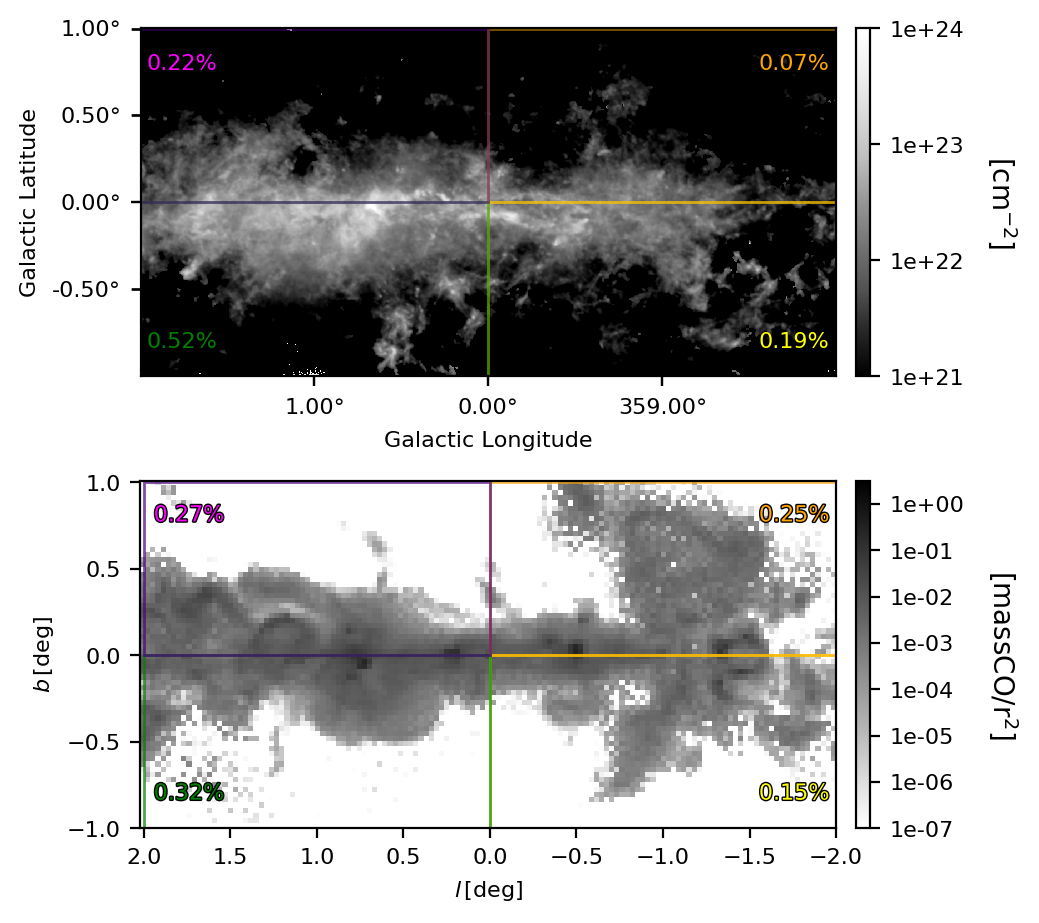

In [133]:
### SIM LB Regions patches ###
L,B = np.meshgrid(ls, bs)

quad1 = (L<0) & (L>=-2) & (B>-1) & (B<=0)
quad2 = (L<0) & (L>=-2) & (B<1) & (B>0)
quad3 = (L>=0) & (L<=2) & (B>-1) & (B<=0)
quad4 = (L>=0) & (L<=2) & (B<1) & (B>0)


### Herschel LB Regions patches ###
R1_min, R1_max = skycoord_to_pixel(SkyCoord(-2., -1., unit="deg", frame='galactic'), 
                                   hers_cutout.wcs), skycoord_to_pixel(SkyCoord(0., 0., unit="deg", 
                                   frame='galactic'), hers_cutout.wcs)
R2_min, R2_max = skycoord_to_pixel(SkyCoord(-2., 0., unit="deg", frame='galactic'), 
                                   hers_cutout.wcs), skycoord_to_pixel(SkyCoord(0., 1., unit="deg", 
                                   frame='galactic'), hers_cutout.wcs)
R3_min, R3_max = skycoord_to_pixel(SkyCoord(0., -1., unit="deg", frame='galactic'), 
                                   hers_cutout.wcs), skycoord_to_pixel(SkyCoord(2., 0., unit="deg", 
                                   frame='galactic'), hers_cutout.wcs)
R4_min, R4_max = skycoord_to_pixel(SkyCoord(0., 0., unit="deg", frame='galactic'), 
                                   hers_cutout.wcs), skycoord_to_pixel(SkyCoord(2., 1., unit="deg", 
                                   frame='galactic'), hers_cutout.wcs)
   
R1_hers = Rectangle((R1_min[0], R1_min[1]), R1_max[0]-R1_min[0]  , R1_max[1]-R1_min[1], 
                 linewidth=1., edgecolor='yellow', facecolor='none', alpha = 0.5)
R2_hers = Rectangle((R2_min[0], R2_min[1]), R2_max[0]-R2_min[0]  , R2_max[1]-R2_min[1], 
                 linewidth=1., edgecolor='orange', facecolor='none', alpha =0.5)
R3_hers = Rectangle((R3_min[0], R3_min[1]), R3_max[0]-R3_min[0]  , R3_max[1]-R3_min[1], 
                 linewidth=1., edgecolor='green', facecolor='none', alpha =0.5)
R4_hers = Rectangle((R4_min[0], R4_min[1]), R4_max[0]-R4_min[0]  , R4_max[1]-R4_min[1], 
                 linewidth=1., edgecolor='indigo', facecolor='none', alpha =0.5)


R1start, R1extent =  (int(R1_min[0]),int(R1_min[1])), (int(R1_max[0]-R1_min[0]), int(R1_max[1]-R1_min[1]))
R2start, R2extent =  (int(R2_min[0]),int(R2_min[1])), (int(R2_max[0]-R2_min[0]), int(R2_max[1]-R2_min[1]))
R3start, R3extent =  (int(R3_min[0]),int(R3_min[1])), (int(R3_max[0]-R3_min[0]), int(R3_max[1]-R3_min[1]))
R4start, R4extent =  (int(R4_min[0]),int(R4_min[1])), (int(R4_max[0]-R4_min[0]), int(R4_max[1]-R4_min[1]))

hers_R1 = make_lb_region_mask(R1start, R1extent, hers_cutout.data)
hers_R2 = make_lb_region_mask(R2start, R2extent, hers_cutout.data)
hers_R3 = make_lb_region_mask(R3start, R3extent, hers_cutout.data)
hers_R4 = make_lb_region_mask(R4start, R4extent, hers_cutout.data)



hers_pos_l_pcent = (np.sum(hers_R3[hers_R3>0])/np.nansum(hers_cutout.data)) + (np.sum(hers_R4[hers_R4>0])/np.nansum(hers_cutout.data))
hers_neg_l_pcent = (np.sum(hers_R1[hers_R1>0])/np.nansum(hers_cutout.data)) + (np.sum(hers_R2[hers_R2>0])/np.nansum(hers_cutout.data))

lb_pos_pcent = (np.sum(lbplot[quad3])/np.sum(lbplot)) + (np.sum(lbplot[quad4])/np.sum(lbplot))
lb_neg_pcent = (np.sum(lbplot[quad1])/np.sum(lbplot)) + (np.sum(lbplot[quad2])/np.sum(lbplot))



### Plots ###
fxsz = 40
xyrat = 2./8.
fysz = fxsz * xyrat
ds = 0.1
fig = plt.figure( figsize=(10,5), dpi=200)
gs = GridSpec(2,1)
gs.update(left=ds, right=1-ds, bottom=ds, top=1-ds, hspace=0.3, wspace=0)


### LB HERSCHEL ###
axes1 = plt.subplot(gs[0, :1], projection=hers_cutout.wcs)
axes2 = plt.subplot(gs[1, :1] )

hers_imshow = axes1.imshow(hers_cutout.data, origin='lower', cmap= 'Greys_r', 
                           norm = colors.SymLogNorm(linthresh=0.5, linscale=1,
                                              vmin=1e21, vmax=1e24)) 


axes1.add_patch(R1_hers)
axes1.add_patch(R2_hers)
axes1.add_patch(R3_hers)
axes1.add_patch(R4_hers)


plt.text(0.94, 0.10, r'{:.2f}%'.format(np.sum(hers_R1[hers_R1>0])/np.nansum(hers_cutout.data)), ha='center', va='center', color = 'yellow', transform=axes1.transAxes, fontsize=8)
plt.text(0.94, 0.90, r'{:.2f}%'.format(np.sum(hers_R2[hers_R2>0])/np.nansum(hers_cutout.data)), ha='center', va='center', color = 'orange', transform=axes1.transAxes, fontsize=8)
plt.text(0.06, 0.10, r'{:.2f}%'.format(np.sum(hers_R3[hers_R3>0])/np.nansum(hers_cutout.data)), ha='center', va='center', color = 'green', transform=axes1.transAxes, fontsize=8)
plt.text(0.06, 0.90, r'{:.2f}%'.format(np.sum(hers_R4[hers_R4>0])/np.nansum(hers_cutout.data)), ha='center', va='center', color = 'magenta', transform=axes1.transAxes, fontsize=8)


divider0= make_axes_locatable(axes1)
cax0 = divider0.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb0  = fig.colorbar(hers_imshow, orientation="vertical", cax = cax0, 
                    ticks=[1e21, 1e22, 1e23, 1e24],format='%.0e')
cb0.set_label(label = r'[cm$^{-2}]$', labelpad=20, y=0.5, rotation=-90, fontsize = 10)
cb0.ax.tick_params(labelsize=8)
cb0.minorticks_off()

lon = axes1.coords[0]
lat = axes1.coords[1]

lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')

axes1.set_ylabel('Galactic Latitude', fontsize=8)
axes1.set_xlabel('Galactic Longitude', fontsize=8)
axes1.tick_params(axis='x', labelsize=8)
axes1.tick_params(axis='y', labelsize=8)


### LB SIM PLOT ###

extent_lb = (ls.min(),ls.max(),bs.min(),bs.max())
levels_lb = logspace(-7,0.5,256)
norm_lb = colors.BoundaryNorm(levels_lb, 256)
im_lb = axes2.imshow(lbplot ,origin='l',extent=extent_lb,cmap='binary',norm=norm_lb)


R1 = Rectangle((-2,-1), 2, 1, edgecolor='yellow', facecolor='none', alpha=0.7)
R2 = Rectangle((-2,0), 2, 1, edgecolor='orange', facecolor='none', alpha=0.7)
R3 = Rectangle((0,-1), 2, 1, edgecolor='green', facecolor='none', alpha=0.7)
R4 = Rectangle((0,0), 2, 1, edgecolor='indigo', facecolor='none', alpha=0.7)
axes2.add_patch(R1)
axes2.add_patch(R2)
axes2.add_patch(R3)
axes2.add_patch(R4)

R1_patch = patches.Patch(color='yellow', label='R1={:.2f}%'.format(np.sum(lbplot[quad1])/np.sum(lbplot)), alpha = 0.4)
R2_patch = patches.Patch(color='orange', label='R2={:.2f}%'.format(np.sum(lbplot[quad2])/np.sum(lbplot)), alpha = 0.4)
R3_patch = patches.Patch(color='green', label='R3={:.2f}%'.format(np.sum(lbplot[quad3])/np.sum(lbplot)), alpha = 0.4)
R4_patch = patches.Patch(color='indigo', label='R4={:.2f}%'.format(np.sum(lbplot[quad4])/np.sum(lbplot)), alpha = 0.4)


plt.text(0.94, 0.10, '{:.2f}%'.format(np.sum(lbplot[quad1])/np.sum(lbplot)), 
         ha='center', va='center', color = 'yellow', transform=axes2.transAxes, fontsize=8,
        path_effects=[pe.withStroke(linewidth=1, foreground="black")])
plt.text(0.94, 0.90, '{:.2f}%'.format(np.sum(lbplot[quad2])/np.sum(lbplot)), 
         ha='center', va='center', color = 'orange', transform=axes2.transAxes, fontsize=8,
        path_effects=[pe.withStroke(linewidth=1, foreground="black")])
plt.text(0.07, 0.10, '{:.2f}%'.format(np.sum(lbplot[quad3])/np.sum(lbplot)), 
         ha='center', va='center', color = 'green', transform=axes2.transAxes, fontsize=8,
        path_effects=[pe.withStroke(linewidth=1, foreground="black")])
plt.text(0.07, 0.90, '{:.2f}%'.format(np.sum(lbplot[quad4])/np.sum(lbplot)), 
         ha='center', va='center', color = 'magenta', transform=axes2.transAxes, fontsize=8,
        path_effects=[pe.withStroke(linewidth=1, foreground="black")])



#axes2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=4, 
#             handles=[R1_patch, R2_patch, R3_patch, R4_patch ],
#            fancybox=True, fontsize=8)


divider2= make_axes_locatable(axes2)
cax2 = divider2.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb2 = fig.colorbar(im_lb, orientation="vertical", cax = cax2,
                   ticks=[1e3,1e2,1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],format='%.0e')
cb2.set_label(label = r'[massCO/r$^{2}]$', labelpad=20, y=0.5, rotation=-90, fontsize = 10)
cb2.ax.tick_params(labelsize=8)


axes2.set_xlim(ls.max(),ls.min())
axes2.set_xlabel(r'$l\, [{\rm deg}]$',fontsize=8)
axes2.set_ylabel(r'$b\, [{\rm deg}]$',fontsize=8)
axes2.tick_params(labelsize=8)



In [ ]:
if (hers_pos_l_pcent-.25) <= lb_pos_pcent <= hers_pos_l_pcent+.25:
    print(True)

# Automate

In [3]:
hdu_hers = pyfits.open('../../FITS/column_properunits_conv36_source_only.fits')[0]
wcs_hers = WCS(hdu_hers.header)

size_l, size_b = 4, 2
size = u.Quantity([size_b, size_l], u.deg) #sets the size of the box you're taking a cutout of
hers_cutout = Cutout2D(hdu_hers.data, SkyCoord(0, 0, unit="deg", frame='galactic'), 
                        size, wcs = wcs_hers)


### Herschel LB Regions patches ###
R1_min, R1_max = skycoord_to_pixel(SkyCoord(-2., -1., unit="deg", frame='galactic'), 
                                   hers_cutout.wcs), skycoord_to_pixel(SkyCoord(0., 0., unit="deg", 
                                   frame='galactic'), hers_cutout.wcs)
R2_min, R2_max = skycoord_to_pixel(SkyCoord(-2., 0., unit="deg", frame='galactic'), 
                                   hers_cutout.wcs), skycoord_to_pixel(SkyCoord(0., 1., unit="deg", 
                                   frame='galactic'), hers_cutout.wcs)
R3_min, R3_max = skycoord_to_pixel(SkyCoord(0., -1., unit="deg", frame='galactic'), 
                                   hers_cutout.wcs), skycoord_to_pixel(SkyCoord(2., 0., unit="deg", 
                                   frame='galactic'), hers_cutout.wcs)
R4_min, R4_max = skycoord_to_pixel(SkyCoord(0., 0., unit="deg", frame='galactic'), 
                                   hers_cutout.wcs), skycoord_to_pixel(SkyCoord(2., 1., unit="deg", 
                                   frame='galactic'), hers_cutout.wcs)
   
R1_hers = Rectangle((R1_min[0], R1_min[1]), R1_max[0]-R1_min[0]  , R1_max[1]-R1_min[1], 
                 linewidth=1., edgecolor='yellow', facecolor='none', alpha = 0.5)
R2_hers = Rectangle((R2_min[0], R2_min[1]), R2_max[0]-R2_min[0]  , R2_max[1]-R2_min[1], 
                 linewidth=1., edgecolor='orange', facecolor='none', alpha =0.5)
R3_hers = Rectangle((R3_min[0], R3_min[1]), R3_max[0]-R3_min[0]  , R3_max[1]-R3_min[1], 
                 linewidth=1., edgecolor='green', facecolor='none', alpha =0.5)
R4_hers = Rectangle((R4_min[0], R4_min[1]), R4_max[0]-R4_min[0]  , R4_max[1]-R4_min[1], 
                 linewidth=1., edgecolor='indigo', facecolor='none', alpha =0.5)
hers_R_list = [R1_hers, R2_hers, R3_hers, R4_hers]

R1start, R1extent =  (int(R1_min[0]),int(R1_min[1])), (int(R1_max[0]-R1_min[0]), int(R1_max[1]-R1_min[1]))
R2start, R2extent =  (int(R2_min[0]),int(R2_min[1])), (int(R2_max[0]-R2_min[0]), int(R2_max[1]-R2_min[1]))
R3start, R3extent =  (int(R3_min[0]),int(R3_min[1])), (int(R3_max[0]-R3_min[0]), int(R3_max[1]-R3_min[1]))
R4start, R4extent =  (int(R4_min[0]),int(R4_min[1])), (int(R4_max[0]-R4_min[0]), int(R4_max[1]-R4_min[1]))

hers_R1 = make_lb_region_mask(R1start, R1extent, hers_cutout.data)
hers_R2 = make_lb_region_mask(R2start, R2extent, hers_cutout.data)
hers_R3 = make_lb_region_mask(R3start, R3extent, hers_cutout.data)
hers_R4 = make_lb_region_mask(R4start, R4extent, hers_cutout.data)




In [522]:
filelist = []
directory = '../../../bentley/sp_res_03/sp_res_03/output/'
for filename in os.listdir(directory):
    basename, ext = os.path.splitext(filename)
    if ext != '.hdf5':
        continue
    try:
        number = int(basename[11:])
    except ValueError:
        continue  # not numeric
    if 779 <= number <= 780:
        # process file
        filename = os.path.join(directory, filename)
        filelist.append(filename)
        filelist.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))


In [523]:
lb_matched_list = []
for snap_i in filelist:
    data_sf, header_sf = read_snapshot_file(snap_i)
    
    ###Read in header information 

    t_sf = header_sf['Time']
    print(snap_i, '{:.3f} Myr'.format(t_sf*98.7))
    
    BoxSize=header_sf['BoxSize']
    rho_sf = data_sf['Density'] * arepoDensity
    mass_sf = np.array(data_sf['Masses'])
    x_sf,y_sf,z_sf=np.array(data_sf['Coordinates']).T
    vx_sf,vy_sf,vz_sf = np.array(data_sf['Velocities']).T #1 km/s in cm
    energy_per_unit_mass = data_sf['InternalEnergy']*arepoEnergy/arepoMass
    xH2, xHp, xCO = data_sf['ChemicalAbundances'].T
    volumes = data_sf['Masses'] / data_sf['Density']

    cell_vol_cm = volumes*arepoVolume #cm3!
    cell_radius_cm = ((3./(4.*np.pi))*cell_vol_cm)**(1./3.) #cm!

    # chemistry stuff
    # nHtot = nHI + nHp + 2*nH2
    # nTOT = nHI + nH2 + nHp + ne + nHe

    ## mH = mH
    ## kb = kb_cgs

    xHe=0.1
    xHI = 1 - xHp -2*xH2
    nHtot = rho_sf/((1. + 4.0 * xHe) * mH)
    nCO = xCO*nHtot #number density of CO

    N_CO = nCO * cell_vol_cm #get number of particles per cell 
    CO_colden_cm = N_CO / cell_radius_cm / cell_radius_cm #col den of particles per cell (cm^-2)
    massesCO = (nCO*28*mH/arepoDensity)*volumes




    phi = 20*pi/180 #phi = 20 degrees
    omega = 4.0

    x_sf,y_sf,z_sf = x_sf-120., y_sf-120., z_sf-120.
    x_sf,y_sf = rotate(x_sf,y_sf,omega*t_sf-phi)


    vx_sf,vy_sf = rotate(vx_sf,vy_sf,omega*t_sf-phi)
    l,b,r,vl,vb,vr = xyz2lbr(x_sf,y_sf,z_sf,vx_sf,vy_sf,vz_sf)
    l, b = l*180/pi, b*180/pi

    # make it faster by cutting points outside range
    tokeep = (abs(l)<12) #& ((x**2+y**2) < 30**2)
    x_sf,y_sf,z_sf,vx_sf,vy_sf,vz_sf,massesCO,CO_colden_cm, l,b,r,vl,vb,vr = x_sf[tokeep],y_sf[tokeep],z_sf[tokeep],vx_sf[tokeep],vy_sf[tokeep],vz_sf[tokeep],massesCO[tokeep],CO_colden_cm[tokeep],l[tokeep],b[tokeep],r[tokeep],vl[tokeep],vb[tokeep],vr[tokeep]



    #rotate again (so that sun is at x=0, y=-8 kpc)
    x_sf,y_sf = rotate(x_sf,y_sf,pi/2.)
    vx_sf,vy_sf = rotate(vx_sf,vy_sf,pi/2.)

    points_sf = np.vstack((x_sf,y_sf,z_sf)).T  

    lvplot,lbplot, ls, bs, vs = find_lbrv_maps(l, b, vr, r, massesCO)
    
    L,B = np.meshgrid(ls, bs)

    quad1 = (L<0) & (L>=-2) & (B>-1) & (B<=0)
    quad2 = (L<0) & (L>=-2) & (B<1) & (B>0)
    quad3 = (L>=0) & (L<=2) & (B>-1) & (B<=0)
    quad4 = (L>=0) & (L<=2) & (B<1) & (B>0)
    
    hers_pos_l_pcent = (np.sum(hers_R3[hers_R3>0])/np.nansum(hers_cutout.data)) + (np.sum(hers_R4[hers_R4>0])/np.nansum(hers_cutout.data))
    hers_neg_l_pcent = (np.sum(hers_R1[hers_R1>0])/np.nansum(hers_cutout.data)) + (np.sum(hers_R2[hers_R2>0])/np.nansum(hers_cutout.data))

    lb_pos_pcent = (np.sum(lbplot[quad3])/np.sum(lbplot)) + (np.sum(lbplot[quad4])/np.sum(lbplot))
    lb_neg_pcent = (np.sum(lbplot[quad1])/np.sum(lbplot)) + (np.sum(lbplot[quad2])/np.sum(lbplot))

    print('lb plot pos_l = {:.2f}%'.format(lb_pos_pcent))
    if (hers_pos_l_pcent-.25) <= lb_pos_pcent <= hers_pos_l_pcent+.25:
        print('plotting for snap!!')
        
        lb_matched_list.append(filename)
        
        
        ### Plots ###
        fxsz = 40
        xyrat = 2./8.
        fysz = fxsz * xyrat
        ds = 0.1
        fig = plt.figure( figsize=(10,5), dpi=200)
        gs = GridSpec(2,1)
        gs.update(left=ds, right=1-ds, bottom=ds, top=1-ds, hspace=0.3, wspace=0.5)
        
        axes1 = plt.subplot(gs[0, :1], projection=hers_cutout.wcs)
        axes2 = plt.subplot(gs[1, :1] )

        ### LB HERSCHEL ###
        R1_hers = Rectangle((R1_min[0], R1_min[1]), R1_max[0]-R1_min[0]  , R1_max[1]-R1_min[1], 
                 linewidth=1., edgecolor='yellow', facecolor='none', alpha = 0.5)
        R2_hers = Rectangle((R2_min[0], R2_min[1]), R2_max[0]-R2_min[0]  , R2_max[1]-R2_min[1], 
                         linewidth=1., edgecolor='orange', facecolor='none', alpha =0.5)
        R3_hers = Rectangle((R3_min[0], R3_min[1]), R3_max[0]-R3_min[0]  , R3_max[1]-R3_min[1], 
                         linewidth=1., edgecolor='green', facecolor='none', alpha =0.5)
        R4_hers = Rectangle((R4_min[0], R4_min[1]), R4_max[0]-R4_min[0]  , R4_max[1]-R4_min[1], 
                         linewidth=1., edgecolor='indigo', facecolor='none', alpha =0.5)
        hers_R_list = [R1_hers, R2_hers, R3_hers, R4_hers] 


        hers_imshow = axes1.imshow(hers_cutout.data, origin='lower', cmap= 'Greys_r', 
                                   norm = colors.SymLogNorm(linthresh=0.5, linscale=1,
                                                      vmin=1e21, vmax=1e24)) 

        axes1.add_patch(R1_hers)
        axes1.add_patch(R2_hers)
        axes1.add_patch(R3_hers)
        axes1.add_patch(R4_hers)
        
        



        plt.text(0.94, 0.10, r'{:.2f}%'.format(np.sum(hers_R1[hers_R1>0])/np.nansum(hers_cutout.data)), ha='center', va='center', color = 'yellow', transform=axes1.transAxes, fontsize=8)
        plt.text(0.94, 0.90, r'{:.2f}%'.format(np.sum(hers_R2[hers_R2>0])/np.nansum(hers_cutout.data)), ha='center', va='center', color = 'orange', transform=axes1.transAxes, fontsize=8)
        plt.text(0.06, 0.10, r'{:.2f}%'.format(np.sum(hers_R3[hers_R3>0])/np.nansum(hers_cutout.data)), ha='center', va='center', color = 'green', transform=axes1.transAxes, fontsize=8)
        plt.text(0.06, 0.90, r'{:.2f}%'.format(np.sum(hers_R4[hers_R4>0])/np.nansum(hers_cutout.data)), ha='center', va='center', color = 'magenta', transform=axes1.transAxes, fontsize=8)


        divider0= make_axes_locatable(axes1)
        cax0 = divider0.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
        cb0  = fig.colorbar(hers_imshow, orientation="vertical", cax = cax0, 
                            ticks=[1e21, 1e22, 1e23, 1e24],format='%.0e')
        cb0.set_label(label = r'[cm$^{-2}]$', labelpad=20, y=0.5, rotation=-90, fontsize = 10)
        cb0.ax.tick_params(labelsize=8)
        cb0.minorticks_off()

        lon = axes1.coords[0]
        lat = axes1.coords[1]

        lon.set_major_formatter('d.dd')
        lat.set_major_formatter('d.dd')

        lon.set_ticks_position('b')
        lon.set_ticklabel_position('b')
        lon.set_axislabel_position('b')
        lat.set_ticks_position('l')
        lat.set_ticklabel_position('l')
        lat.set_axislabel_position('l')

        axes1.set_ylabel('Galactic Latitude', fontsize=8)
        axes1.set_xlabel('Galactic Longitude', fontsize=8)
        axes1.tick_params(axis='x', labelsize=8)
        axes1.tick_params(axis='y', labelsize=8)


        ### LB SIM PLOT ###

        extent_lb = (ls.min(),ls.max(),bs.min(),bs.max())
        levels_lb = logspace(-7,0.5,256)
        norm_lb = colors.BoundaryNorm(levels_lb, 256)
        im_lb = axes2.imshow(lbplot ,origin='lower',extent=extent_lb,cmap='binary',norm=norm_lb)


        R1 = Rectangle((-2,-1), 2, 1, edgecolor='yellow', facecolor='none', alpha=0.7)
        R2 = Rectangle((-2,0), 2, 1, edgecolor='orange', facecolor='none', alpha=0.7)
        R3 = Rectangle((0,-1), 2, 1, edgecolor='green', facecolor='none', alpha=0.7)
        R4 = Rectangle((0,0), 2, 1, edgecolor='indigo', facecolor='none', alpha=0.7)
        axes2.add_patch(R1)
        axes2.add_patch(R2)
        axes2.add_patch(R3)
        axes2.add_patch(R4)

        R1_patch = patches.Patch(color='yellow', label='R1={:.2f}%'.format(np.sum(lbplot[quad1])/np.sum(lbplot)), alpha = 0.4)
        R2_patch = patches.Patch(color='orange', label='R2={:.2f}%'.format(np.sum(lbplot[quad2])/np.sum(lbplot)), alpha = 0.4)
        R3_patch = patches.Patch(color='green', label='R3={:.2f}%'.format(np.sum(lbplot[quad3])/np.sum(lbplot)), alpha = 0.4)
        R4_patch = patches.Patch(color='indigo', label='R4={:.2f}%'.format(np.sum(lbplot[quad4])/np.sum(lbplot)), alpha = 0.4)


        plt.text(0.94, 0.10, '{:.2f}%'.format(np.sum(lbplot[quad1])/np.sum(lbplot)), 
                 ha='center', va='center', color = 'yellow', transform=axes2.transAxes, fontsize=8,
                path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        plt.text(0.94, 0.90, '{:.2f}%'.format(np.sum(lbplot[quad2])/np.sum(lbplot)), 
                 ha='center', va='center', color = 'orange', transform=axes2.transAxes, fontsize=8,
                path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        plt.text(0.07, 0.10, '{:.2f}%'.format(np.sum(lbplot[quad3])/np.sum(lbplot)), 
                 ha='center', va='center', color = 'green', transform=axes2.transAxes, fontsize=8,
                path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        plt.text(0.07, 0.90, '{:.2f}%'.format(np.sum(lbplot[quad4])/np.sum(lbplot)), 
                 ha='center', va='center', color = 'magenta', transform=axes2.transAxes, fontsize=8,
                path_effects=[pe.withStroke(linewidth=1, foreground="black")])



        #axes2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=4, 
        #             handles=[R1_patch, R2_patch, R3_patch, R4_patch ],
        #            fancybox=True, fontsize=8)


        divider2= make_axes_locatable(axes2)
        cax2 = divider2.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
        cb2 = fig.colorbar(im_lb, orientation="vertical", cax = cax2,
                           ticks=[1e3,1e2,1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],format='%.0e')
        cb2.set_label(label = r'[massCO/r$^{2}]$', labelpad=20, y=0.5, rotation=-90, fontsize = 10)
        cb2.ax.tick_params(labelsize=8)


        axes2.set_xlim(ls.max(),ls.min())
        axes2.set_xlabel(r'$l\, [{\rm deg}]$',fontsize=8)
        axes2.set_ylabel(r'$b\, [{\rm deg}]$',fontsize=8)
        axes2.tick_params(labelsize=8)
        
        axes1.set_title('Herschel Col Den', fontsize=8)
        
        axes2.set_title('snap {}'.format(snap_i[55:58]),fontsize= 8, y=0.97)
        plt.savefig('../lb_match/snap_{}_lb_match.png'.format(snap_i[55:58]), bbox_inches='tight')

        
        
        plt.close(fig)

../../../bentley/sp_res_03/sp_res_03/output/whole_disk_779.hdf5 261.004 Myr


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater


lb plot pos_l = 0.59%
plotting for snap!!
../../../bentley/sp_res_03/sp_res_03/output/whole_disk_780.hdf5 261.022 Myr


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater


lb plot pos_l = 0.59%
plotting for snap!!
